In [1]:
## IPython extension to reload modules before executing user code.
# Autorelad is an IPython extension to reload modules before executing user code.
%load_ext autoreload

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [2]:
from matplotlib import pyplot as plt

import os
from os.path import join
import sys
from IPython.display import display
from PIL import Image

ROOT_DIR = os.sep.join(os.path.abspath(".").split(os.sep)[:-2])
sys.path.insert(0, ROOT_DIR)
DATASET_DIR = "{}/data".format(ROOT_DIR)
print(DATASET_DIR)

/home/djoy2409-wsl/projects/software_development/qsar_w_gnns/data


In [3]:
from typing import List, Union, Any, Tuple
from datetime import datetime
from random import sample

import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch_geometric
from torch_geometric.data import Data
from torch.nn import BCELoss, LeakyReLU, ReLU
from torch.optim import lr_scheduler, Adagrad, Adadelta, Adam, AdamW

from rdkit import Chem, RDLogger
from rdkit.Chem import (
    Draw,
    AllChem,
    PandasTools,
    MolFromSequence,
    MolFromSmiles,
    MolToSmiles,
    MolToInchiKey,
    Descriptors,
    GraphDescriptors,
)
from rdkit.Chem import rdMolDescriptors as rdmdesc

from joblib import Parallel, delayed

RDLogger.DisableLog("rdApp.*")
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
from lib import (
    gnn_utils,
    utilities,
    datasets,
    splitters,
    featurizers,
    training_utils,
    graph_nns,
    graph_utils,
)


from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score,
    balanced_accuracy_score,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from lib import gnn_explainer, utilities, visuals, predictions
from lib.datasets import CustomBatch

In [4]:
## Set seeds
seed = 123
utilities.set_seeds(seed=seed, torch_use_deterministic_algos=False)

In [5]:
gcn_predictor = torch.load(f"{DATASET_DIR}/models/dd2_class_best_gcn_predictor.pt")
gat_predictor = torch.load(f"{DATASET_DIR}/models/dd2_class_gat_predictor.pt")
gin_predictor = torch.load(f"{DATASET_DIR}/models/dd2_class_gin_predictor.pt")

In [6]:
dd2_dataset_fname = f'{DATASET_DIR}/dd2_datasets.pt'
dd2_dataset = torch.load(dd2_dataset_fname)

train_dataset = dd2_dataset['train_dataset']
val_dataset   = dd2_dataset['val_dataset']
test_dataset  = dd2_dataset['test_dataset']

dd2_loader_fname = f"{DATASET_DIR}/dd2_dataloaders.pt"
dd2_loaders = torch.load(dd2_loader_fname)

train_loader = dd2_loaders["train_loader"]
val_loader = dd2_loaders["val_loader"]
test_loader = dd2_loaders["test_loader"]


gat_dd2_loader_fname = f'{DATASET_DIR}/dd2_dataloaders_for_gat.pt'
gat_dd2_loaders = torch.load(gat_dd2_loader_fname)

gat_train_loader = gat_dd2_loaders['train_loader']
gat_val_loader   = gat_dd2_loaders['val_loader']
gat_test_loader  = gat_dd2_loaders['test_loader']

gin_dd2_loader_fname = f'{DATASET_DIR}/dd2_dataloaders_for_gin.pt'
gin_dd2_loaders = torch.load(gin_dd2_loader_fname)

gin_train_loader = gin_dd2_loaders['train_loader']
gin_val_loader   = gin_dd2_loaders['val_loader']
gin_test_loader  = gin_dd2_loaders['test_loader']

In [7]:
## Predict with GCN
smiles = ["CCC(=O)NCc1nccc1CO", "O=C(O)c1cccnc1Sc1cc(CCO)c(Cl)cc1"]
new_preds = gcn_predictor.predict_from_smiles_list(
    smiles_list=smiles, device="cpu", desc="Predicting...", return_class_as_proba=True
)

threshold = 0.5
print(new_preds)
pred_classes = [int(x > threshold) for x in new_preds.squeeze(1)]
print("\nnew_preds", new_preds.detach())
print("pred_classes", pred_classes)
print(
    "\ngcn_predictor.add_global_feats_to_nodes:",
    gcn_predictor.add_global_feats_to_nodes,
)

Clean features...
add_global_feats_to_nodes True
dataset after adding global feat:  [Data(x=[13, 238], edge_index=[2, 39], edge_attr=[39, 24]), Data(x=[20, 238], edge_index=[2, 62], edge_attr=[62, 24])]
loader:  DataBatch(x=[33, 238], edge_index=[2, 101], edge_attr=[101, 24], batch=[33], ptr=[3])
tensor([[1.],
        [1.]], grad_fn=<CatBackward0>)

new_preds tensor([[1.],
        [1.]])
pred_classes [1, 1]

gcn_predictor.add_global_feats_to_nodes: True


In [8]:
## Predict with GAT
new_preds = gat_predictor.predict_from_smiles_list(
    smiles_list=smiles, device="cpu", desc="Predicting...", return_class_as_proba=True
)

threshold = 0.5
pred_classes = [int(x > threshold) for x in new_preds.squeeze(1)]
print("\nnew_preds", new_preds.detach())
print("pred_classes", pred_classes)

Clean features...
add_global_feats_to_nodes False
loader:  DataBatch(x=[33, 73], edge_index=[2, 101], edge_attr=[101, 24], global_feats=[2, 174], batch=[33], ptr=[3])

new_preds tensor([[1.],
        [1.]])
pred_classes [1, 1]


In [9]:
## Predict with GIN
new_preds = gin_predictor.predict_from_smiles_list(
    smiles_list=smiles, device="cpu", desc="Predicting...", return_class_as_proba=True
)

threshold = 0.5
pred_classes = [int(x > threshold) for x in new_preds.squeeze(1)]
print("\nnew_preds", new_preds.detach())
print("pred_classes", pred_classes)

Clean features...
add_global_feats_to_nodes False
loader:  DataBatch(x=[33, 73], edge_index=[2, 101], edge_attr=[101, 24], global_feats=[2, 85], batch=[33], ptr=[3])

new_preds tensor([[0.4495],
        [0.5833]])
pred_classes [0, 1]


<h4 style="font-family: cursive">Explanation</h4>
It is important to be able to explain model predictions. GNNs offer several advantages regarding interpretability. Among others:
<ol>
<li>GNNs naturally work with graph-structured data, making it easy to interpret how entities (nodes) are influenced by their neighbors and the overall network. Unlike traditional neural networks that treat inputs as independent features, GNNs explicitly model relationships, providing insight into how these connections contribute to the model's predictions.</li>
<li>GNNs can capture both local interactions (between neighboring nodes) and global structure (via message passing), making it easier to understand how node and edge relationships affect outcomes.</li>
<li><b>Node-Level Interpretability:</b> GNNs can provide insights into which nodes (or features of nodes) are most important for a prediction. For example, by analyzing node embeddings or feature aggregation during message passing, one can identify which nodes have the strongest influence on a target node’s prediction.</li>
<li><b>Edge-Level Interpretability:</b> Edge weights or attention mechanisms (as seen in Graph Attention Networks, or GATs) can highlight which edges (connections between nodes) are most important. This is useful in understanding how specific relationships between nodes contribute to the prediction.</li>
</ol>

<p style="color:blue">In this notebook, we will use several methods to explain predictions using various GNN models, and visualize the explanations.  including <b>Pytorch Geometric (pyG)</b> 'explain' module, subgraph counting using networkX, subgraphX (using Monte Carlo Tree Search), and a feature attribution method (leveraging a custom substructure-based fingerprint) We will use the explain module from , as well as <b>networkX</b> to generate and visualize explanations.</p>

There are some really good blogs describing how to implement explanation capabilities for GNNs. However, when dealing with molecules, which one wants to visualize for easy and intuitive interpretation, only a few provide great examples. I found these resources helpful:

1. <a href="https://medium.com/stanford-cs224w/why-should-i-trust-my-graph-neural-network-4d964052bd85">Why should I trust my Graph Neural Network?</a>
2. <a href="https://github.com/pyg-team/pytorch_geometric/blob/master/examples/explain/gnn_explainer.py">PyTorch Geometric GNNExplainer example.</a>
3. <a href="https://hal.science/hal-04660442/document">Bugueno <em>et al.</em> (2024) Graph-Based Explainable AI: A Comprehensive Survey</a>


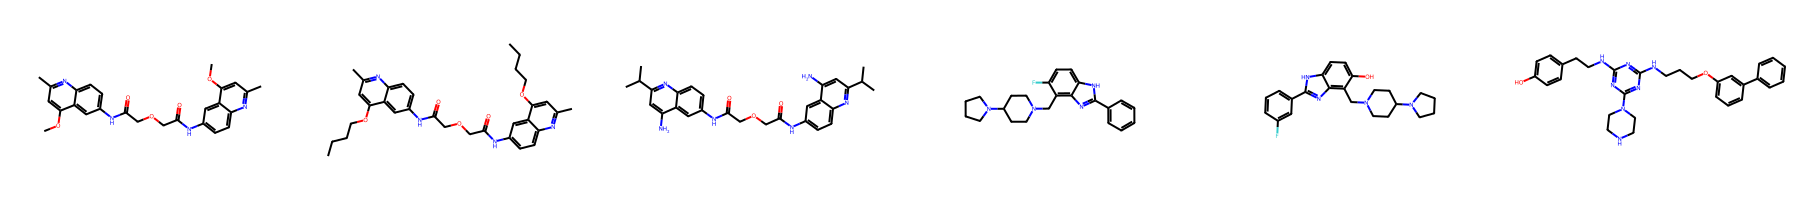

In [10]:
smiles_and_labels = pickle.load(
    open(f"{DATASET_DIR}/dd2_splits_smiles_and_labels.pkl", "rb")
)
# print(len(smiles_and_labels['test'][0]))

test_molecules = [MolFromSmiles(x) for x in smiles_and_labels["test"][0]]
test_labels = [
    "DD2 active" if x == 1 else "DD2 inactive" for x in smiles_and_labels["test"][1]
]
# print(test_labels)

Draw.MolsToGridImage(
    [MolFromSmiles(x) for x in smiles_and_labels["test"][0][:6]],
    molsPerRow=6,
    subImgSize=(300, 200),
)

In [11]:
%%time

graphs_from_test_mols = gnn_utils.get_dataset_from_mol_list(
    mol_list=test_molecules,
    targets=smiles_and_labels["test"][1],
    atom_featurizer=gcn_predictor.atom_featurizer,
    bond_featurizer=gcn_predictor.bond_featurizer,
    add_explicit_h=True,
    mol_featurizer=gcn_predictor.mol_featurizer,
    compute_global_features=True,
    add_global_feat_to_nodes=True,
    scale_features=True,
    feature_scaler=StandardScaler(),
)

# ## Lets add the true labels
# print(len(graphs_from_test_mols))
# for i in range(len(graphs_from_test_mols)):
#     graphs_from_test_mols[i].y = smiles_and_labels['test'][1][i]

graphs_from_test_mols[0]

Clean features...
global_feats_reshaped (676, 165)
CPU times: user 22.1 s, sys: 0 ns, total: 22.1 s
Wall time: 21.6 s


Data(x=[35, 238], edge_index=[2, 111], edge_attr=[111, 24], y=[1])

In [12]:
features_mapping = gcn_predictor.atom_featurizer.features_mapping
print(features_mapping["atomic_num"])

node_dict = {
    features_mapping["atomic_num"][i]: Chem.Atom(i).GetSymbol()
    if not i == "unk"
    else "unk"
    for i in features_mapping["atomic_num"]
}
print("node_dict = ", node_dict)

# ## Generated color code https://g.co/kgs/FuoNWHq
# node_colors = ['#EDF2EF', '#EDE6D8', '#4970C6', '#FF5357', '#D446DB', 'brown', '#F2F05C', '#7AF246', '#C9C720', '#AD49C6', '#C66F49']

{1: 0, 6: 1, 7: 2, 8: 3, 9: 4, 15: 5, 16: 6, 17: 7, 35: 8, 53: 9, 'unk': 10}
node_dict =  {0: 'H', 1: 'C', 2: 'N', 3: 'O', 4: 'F', 5: 'P', 6: 'S', 7: 'Cl', 8: 'Br', 9: 'I', 10: 'unk'}


In [13]:
gcn_xp_module = gnn_explainer.GNNExplainerModule(
    gnn_predictor=gcn_predictor,
    node_dict=node_dict,
    num_epochs=500,
    lr=0.05,
    node_mask_type="attributes",
    edge_mask_type="object",
    explanation_type="model",
    model_config=dict(
        mode="binary_classification", task_level="graph", return_type="raw"
    ),
    node_colors=None,
    device="cpu",
)


gat_xp_module = gnn_explainer.GNNExplainerModule(
    gnn_predictor=gat_predictor,
    node_dict=node_dict,
    num_epochs=500,
    lr=0.05,
    node_mask_type="attributes",
    edge_mask_type="object",
    explanation_type="model",
    model_config=dict(
        mode="binary_classification", task_level="graph", return_type="raw"
    ),
    node_colors=None,
    device="cpu",
)

gin_xp_module = gnn_explainer.GNNExplainerModule(
    gnn_predictor=gin_predictor,
    node_dict=node_dict,
    num_epochs=500,
    lr=0.05,
    node_mask_type="attributes",
    edge_mask_type="object",
    explanation_type="model",
    model_config=dict(
        mode="binary_classification", task_level="graph", return_type="raw"
    ),
    node_colors=None,
    device="cpu",
)

# print(gcn_xp_module)
# print(gat_xp_module)
# print(gin_xp_module)

add_global_feats_to_nodes True
current_num_feats_x = 238  / x_dim = 238
loader:  DataBatch(x=[35, 238], edge_index=[2, 111], edge_attr=[111, 24], y=[1], batch=[35], ptr=[2])


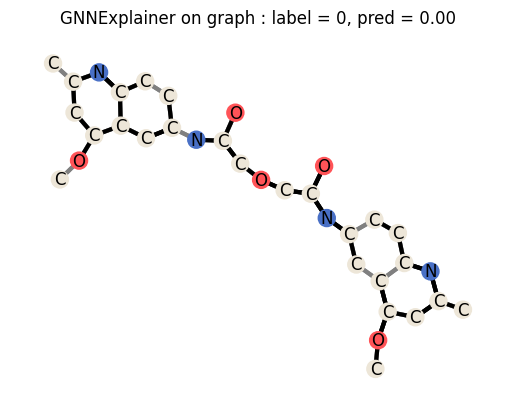

dict_keys(['atomic_num', 'n_valence', 'formal_charge', 'n_hydrogens', 'hybridization', 'chiral_tag', 'is_aromatic', 'is_in_ring', 'is_in_ring_size_5', 'is_in_ring_size_6', 'is_h_acceptor', 'is_h_donor', 'is_heteroatom', 'atomic_mass', 'atomic_vdw_radius', 'atomic_covalent_radius', 'num_implicit_hydrogens', 'num_explicit_hydrogens', 'crippen_log_p_contrib', 'labute_asa_contrib'])


(torch.Size([15908, 238]), GCNConv(238, 444))

In [14]:
# print(batch_from_test_mols[0])
# print(gcn_predictor.predict_from_data_list(data=graphs_from_test_mols, add_global_feats_to_nodes=True).detach().tolist())

# print(graphs_from_test_mols[0])
gcn_xp_module.visualize_explanation_for_graph(
    my_data=graphs_from_test_mols[0],
    threshold=0.5,
    device="cpu",
    node_size=150,
    edge_width=3,
)
print(gcn_xp_module.gnn_predictor.atom_featurizer.features_mapping.keys())
next(iter(train_loader)).x.shape, gcn_xp_module.gnn_predictor.model.conv1

Clean features...
global_feats_reshaped (676, 174)
add_global_feats_to_nodes False
loader:  DataBatch(x=[35, 73], edge_index=[2, 111], edge_attr=[111, 24], global_feats=[1, 174], y=[1], batch=[35], ptr=[2])


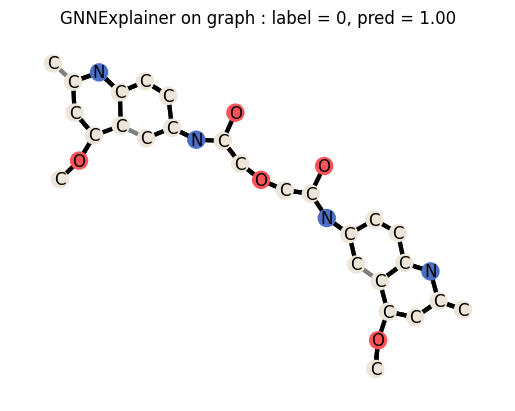

1

In [15]:
gat_graphs_from_test_mols = gnn_utils.get_dataset_from_mol_list(
    mol_list=test_molecules,
    targets=smiles_and_labels["test"][1],
    atom_featurizer=gat_predictor.atom_featurizer,
    bond_featurizer=gat_predictor.bond_featurizer,
    add_explicit_h=False,
    mol_featurizer=gat_predictor.mol_featurizer,
    compute_global_features=True,
    add_global_feat_to_nodes=False,
    scale_features=True,
    feature_scaler=StandardScaler(),
)

gat_xp_module.visualize_explanation_for_graph(
    my_data=gat_graphs_from_test_mols[0],
    threshold=0.5,
    device="cpu",
    node_size=150,
    edge_width=3,
)

torch.Tensor([1,2, 4]).ndim

Clean features...
global_feats_reshaped (676, 85)
add_global_feats_to_nodes False
loader:  DataBatch(x=[35, 73], edge_index=[2, 111], edge_attr=[111, 24], global_feats=[1, 85], y=[1], batch=[35], ptr=[2])


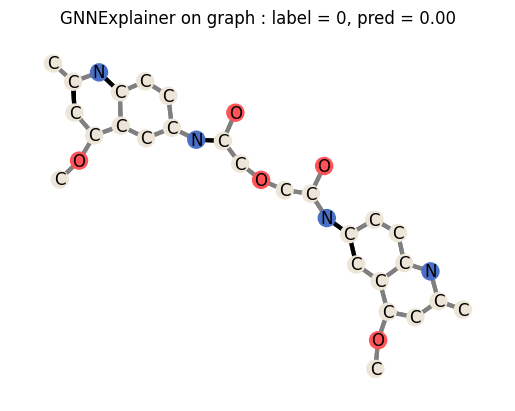

In [16]:
## With the GIN

gin_graphs_from_test_mols = gnn_utils.get_dataset_from_mol_list(
    mol_list=test_molecules,
    targets=smiles_and_labels["test"][1],
    atom_featurizer=gin_predictor.atom_featurizer,
    bond_featurizer=gin_predictor.bond_featurizer,
    add_explicit_h=False,
    mol_featurizer=gin_predictor.mol_featurizer,
    compute_global_features=True,
    add_global_feat_to_nodes=False,
    scale_features=True,
    feature_scaler=StandardScaler(),
)

# print(gin_xp_module.gnn_predictor.model)
gin_xp_module.visualize_explanation_for_graph(
    my_data=gin_graphs_from_test_mols[0],
    threshold=0.5,
    device="cpu",
    node_size=150,
    edge_width=3,
)

<h5 style="font-family: cursive">Interactive visualization of explanations</h5>

In [17]:
## With The GCN
# data=test_loader.dataset[:25]
gcn_xp_module.interactive_explanation_viz_for_graphs(
    graphs=graphs_from_test_mols, node_size=150, edge_width=3
)


### Interactive exploration of GNNExplainer explanations ###



interactive(children=(IntSlider(value=0, description='graph_idx', max=25), FloatSlider(value=0.5, description=…

In [18]:
## With the GAT
gat_xp_module.interactive_explanation_viz_for_graphs(
    graphs=gat_graphs_from_test_mols, node_size=150, edge_width=3
)


### Interactive exploration of GNNExplainer explanations ###



interactive(children=(IntSlider(value=0, description='graph_idx', max=25), FloatSlider(value=0.5, description=…

In [19]:
## With the GIN
gin_xp_module.interactive_explanation_viz_for_graphs(
    graphs=gin_graphs_from_test_mols, node_size=150, edge_width=3
)


### Interactive exploration of GNNExplainer explanations ###



interactive(children=(IntSlider(value=0, description='graph_idx', max=25), FloatSlider(value=0.5, description=…

<h5 style="font-family: cursive">Predicting via subgraphs</h5>

<p>Below, we will train and evaluate a logistic regression model built using fesatures(subgraphs) that were identified using the subgraph counting method. tThese features use these as features to predict the outcome. The features (subgraphs) can also be used to explain predictions, and we can see which are the most important ones.</p>
<p>This is a time and computation expensive process, since the time it takes to explicitly enumerate all subgraphs grows exponentially with k (max size of a subgraph). We will therefore limit the size of the training set to 1500.</p>



In [20]:
# %%time
# subgraph_size=5


# ##Train model
# gcn_xp_module.train_subgraph_based_logreg_predictor(train_dataset[:1500], subgraph_size=subgraph_size)

# ## Evaluate model
# gcn_xp_module.evaluate_subgraph_based_logreg_predictor(test_dataset[:])

In [21]:
# gcn_xp_module.visualize_top_k_subgraphs(k=2)

In [22]:
# print("\n", gcn_predictor.atom_featurizer.features_mapping)
# print("\n", gcn_predictor.node_dict)

In [23]:
%%time
# gcn_xp_module.visualize_subgraphx_explanations(dataset=graphs_from_test_mols[:2], 
#                                                 device = 'cpu', num_nodes=10, node_size=150, 
#                                                 edge_width=3)
gcn_xp_module.interactive_subgraphx_based_explanation_viz_for_graphs(
    dataset=graphs_from_test_mols[:5],
    device="cpu",
    num_nodes=10,
    max_num=25,
    threshold=0.5,
    node_size=150,
    edge_width=3,
    high2low=True,  ## Whether to expand children nodes from high degree to low degree  when extending the child nodes in the search tree. (default is False)
    num_expand_nodes=20,  # The number of nodes to expand when extending the child nodes in the search tree. (default=14)
    c_puct=15,  # The hyperparameter that encourages exploration. (default=10.0)
)


### Interactive exploration of GNNExplainer explanations ###



interactive(children=(IntSlider(value=0, description='graph_idx', max=5), FloatSlider(value=0.5, description='…

CPU times: user 20.4 s, sys: 102 ms, total: 20.5 s
Wall time: 1.5 s


In [24]:
# gat_xp_module.visualize_subgraphx_explanations(dataset=graphs_from_test_mols[:2], device = 'cpu', num_nodes=10, node_size=150, edge_width=3)
# print(gat_xp_module.gnn_predictor.model)
# print(gat_xp_module.gnn_predictor.add_global_feats_to_nodes)
print(gat_graphs_from_test_mols[0])
gat_xp_module.interactive_subgraphx_based_explanation_viz_for_graphs(
    dataset=gat_graphs_from_test_mols[:5],
    device="cpu",
    num_nodes=10,
    max_num=25,
    threshold=0.5,
    node_size=150,
    edge_width=3,
    high2low=True,
)

Data(x=[35, 73], edge_index=[2, 111], edge_attr=[111, 24], global_feats=[174], y=[1])

### Interactive exploration of GNNExplainer explanations ###



interactive(children=(IntSlider(value=0, description='graph_idx', max=5), FloatSlider(value=0.5, description='…

Data(x=[35, 73], edge_index=[2, 111], edge_attr=[111, 24], global_feats=[85], y=[1])
global_feats torch.Size([1, 85])


100%|██████████| 20/20 [00:00<00:00, 26.80it/s]


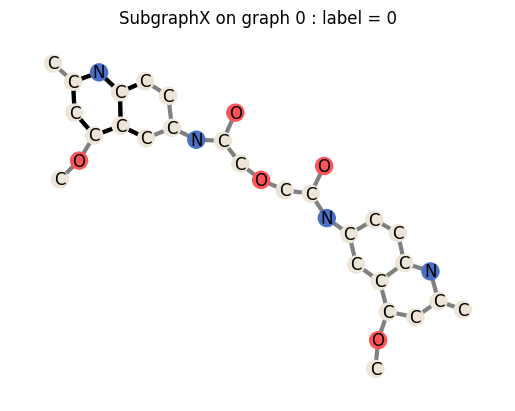

In [25]:
print(gin_graphs_from_test_mols[0])
gin_xp_module.visualize_subgraphx_explanations(
    dataset=gin_graphs_from_test_mols[:1],
    device="cpu",
    num_nodes=10,
    node_size=150,
    edge_width=3,
    high2low=False,
    num_expand_nodes=5,
    c_puct=30,
)
# gin_xp_module.interactive_subgraphx_based_explanation_viz_for_graphs(dataset=graphs_from_test_mols[:5], device = 'cpu', num_nodes=10, max_num = 25, threshold = 0.5, node_size=150, edge_width=3, high2low=True, num_expand_nodes=20, c_puct=15)

<h5 style="font-family: cursive">Using Feature Attribution on Fingerprints</h5>
<p style="font-family: cursive">We will use the GCN model that was trained using custom fingerprints. Here, we compute the importance of the features (substructures) that constitute the fingerprint. The explanation function uses is a gradient-based feature attribution, which consists of the following steps:
</p>
<ol style="font-family: cursive">
<li><b>Forward pass:</b> The model comuputes an output, i.e.: the prediction.</li>
<li><b>Gradient calculation:</b> The gradients of the output are calculated with respect to the subtructures. These gradients show sensitive the output prediction is to changes in each substructure.</li>
<li><b>Feature attribution:</b> Creates the feature attribution map using the gradients to indicate which part of the input had the largest effect on pushing the model towards or away from the final prediction.</li>
</ol>

In [26]:
# gat_predictor.mol_featurizer.

[H]c1c([H])c(-c2nc(C([H])([H])[H])c3c([H])nc(N([H])c4c([H])c([H])c(OC([H])([H])C([H])([H])N5C([H])([H])C([H])([H])C([H])([H])C5([H])[H])c([H])c4[H])nn23)c([H])c(C(F)(F)F)c1[H]
Prediction (Pos class proba) = 0.729 (0.9913839101791382)
[0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.19593381881713867, 0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.74419105052948, 0.0, 0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.30653688311576843, 0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.27612537145614624, 0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.35871627926826477, 0.1668703854084015, 0.24309229850769043, 0.24309229850769043, 0.24309229850769043, 0.7226291298866272, 0.24309229850769043, 0.3202315866947174, 0.24309229

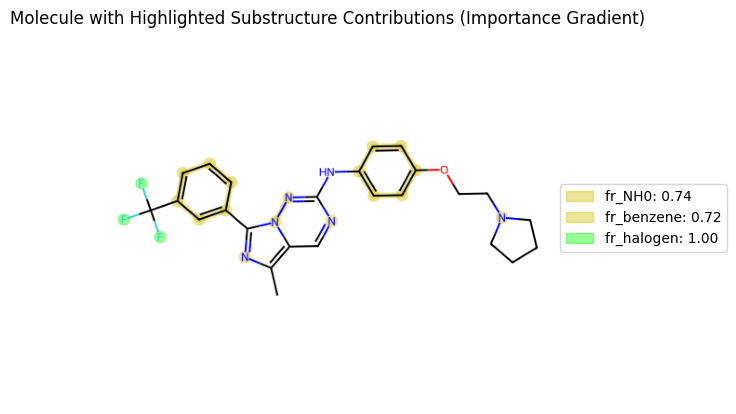

In [27]:
# import torch

# print(best_gcn_model.global_fdim)

smi = smiles_and_labels["test"][0][20]
print(smi)
# my_graph =  gnn_utils.graph_from_molecule(
#     molecule        = MolFromSmiles(smi),
#     atom_featurizer = gat_predictor.atom_featurizer,
#     bond_featurizer = gat_predictor.bond_featurizer,
#     mol_featurizer  = gat_predictor.mol_featurizer,
#     add_explicit_h  = bool,
#     compute_global_features = gat_predictor.compute_global_features,
#     add_global_feat_to_nodes = gat_predictor.add_global_feats_to_nodes,
# )
# print(gat_predictor.compute_global_features)
# print(my_graph)

predictions.predict_and_visualize_subsructure_contributions(
    model=gin_predictor.model,
    smiles=smi,
    threshold=0.5,
    atom_featurizer=gin_predictor.atom_featurizer,
    bond_featurizer=gin_predictor.bond_featurizer,
    mol_featurizer=gin_predictor.mol_featurizer,
    normalize_contributions=True,
    func_groups=gin_predictor.mol_featurizer.df_func_gps.values.tolist(),
    scale_type="log",
)

<h4 style="font-family: cursive">Visualizing The Embeddings</h4>

In [28]:
from lib import gnn_utils, datasets, utilities, visuals
from torch_geometric.data import Batch

<h5 style="font-family: cursive">ECFP4 embeddings</h5>

In [29]:
test_ecfp4s_ = utilities.calculate_fingerprints_as_bits(
    molecules=test_molecules, fingerprint_type="morgan", radius=2, nBits=1024
)
# test_ecfp4s_df = pd.DataFrame(ecfp4s_ )

/home/djoy2409-wsl/anaconda3/envs/chemai-gpu/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


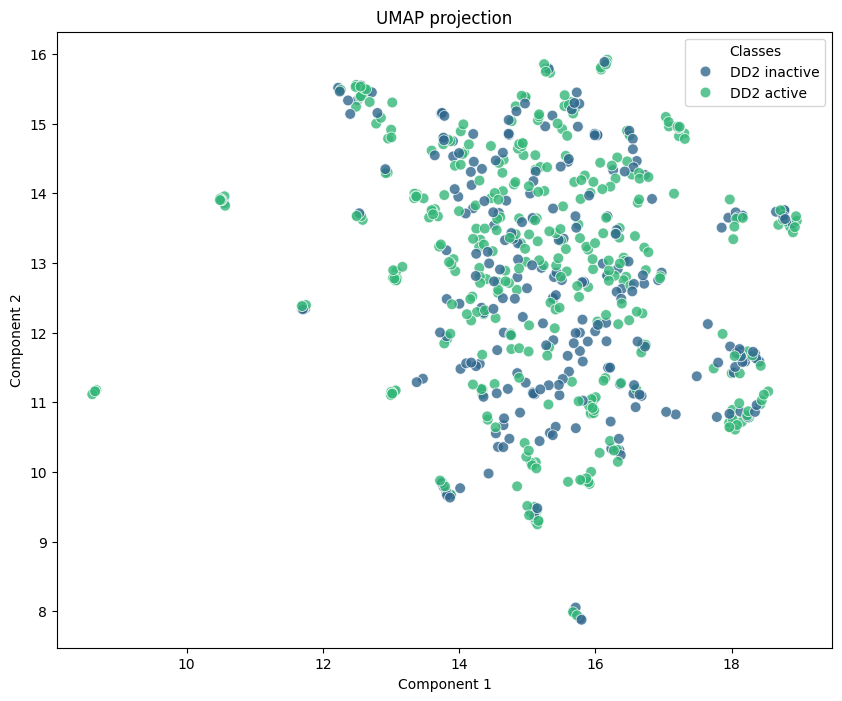

In [30]:
ecfp4s_embeddings_umap = visuals.reduce_and_plot(
    data=test_ecfp4s_,
    actuals=test_labels[:],
    method="umap",
    n_components=2,
    random_state=seed,
    n_neighbors=20,
    min_dist=0.1,
)
# ecfp4s_embeddings_tsne = visuals.reduce_and_plot(data=test_ecfp4s_[:], actuals=test_labels[:], method='tsne', n_components=2, random_state=seed, perplexity=5.0)

In [31]:
%%time

batch_from_test_mols = CustomBatch.from_data_list(graphs_from_test_mols).to("cpu")
print(f"batch_from_test_mols = {batch_from_test_mols}")
batch_gcn_embeddings = gcn_predictor.model.get_embedding(batch_from_test_mols).detach()
print("batch_gcn_embeddings: ", batch_gcn_embeddings.shape)
# batch_gcn_embeddings

batch_from_test_mols = DataCustomBatch(x=[21277, 238], edge_index=[2, 67835], edge_attr=[67835, 24], y=[676], batch=[21277], ptr=[677])
batch_gcn_embeddings:  torch.Size([676, 444])
CPU times: user 3.22 s, sys: 918 ms, total: 4.13 s
Wall time: 406 ms


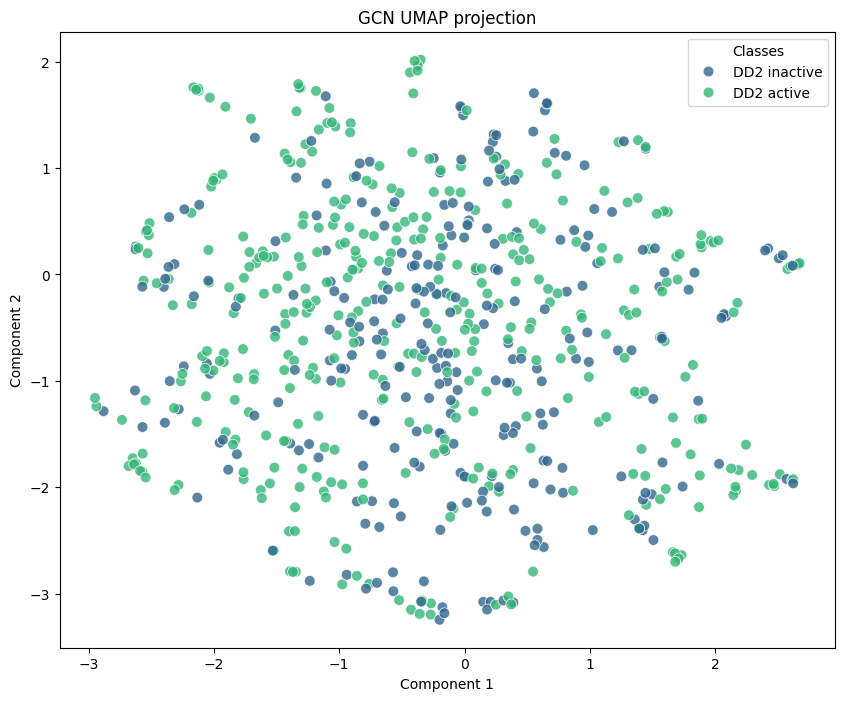

In [37]:
batch_gcn_embeddings_umap = visuals.reduce_and_plot(
    data=batch_gcn_embeddings.detach().to("cpu"),
    actuals=test_labels[:],
    method="umap",
    n_components=2,
    random_state=seed,
    n_neighbors=20,
    min_dist=0.1,
    title="GCN UMAP projection"
)

In [33]:
gin_graphs_from_test_mols[0].global_feats.ndim

1

In [34]:
gin_batch_from_test_mols = CustomBatch.from_data_list(gin_graphs_from_test_mols).to("cpu")
print(gin_batch_from_test_mols)
batch_gin_embeddings = gin_predictor.model.get_embedding(gin_batch_from_test_mols).detach()
print("batch_gin_embeddings: ", batch_gin_embeddings.shape)
# batch_gin_embeddings

DataCustomBatch(x=[21277, 73], edge_index=[2, 67835], edge_attr=[67835, 24], global_feats=[676, 85], y=[676], batch=[21277], ptr=[677])
global_feats shape torch.Size([676, 85])
global_feats torch.Size([676, 85])
batch_gin_embeddings:  torch.Size([676, 283])


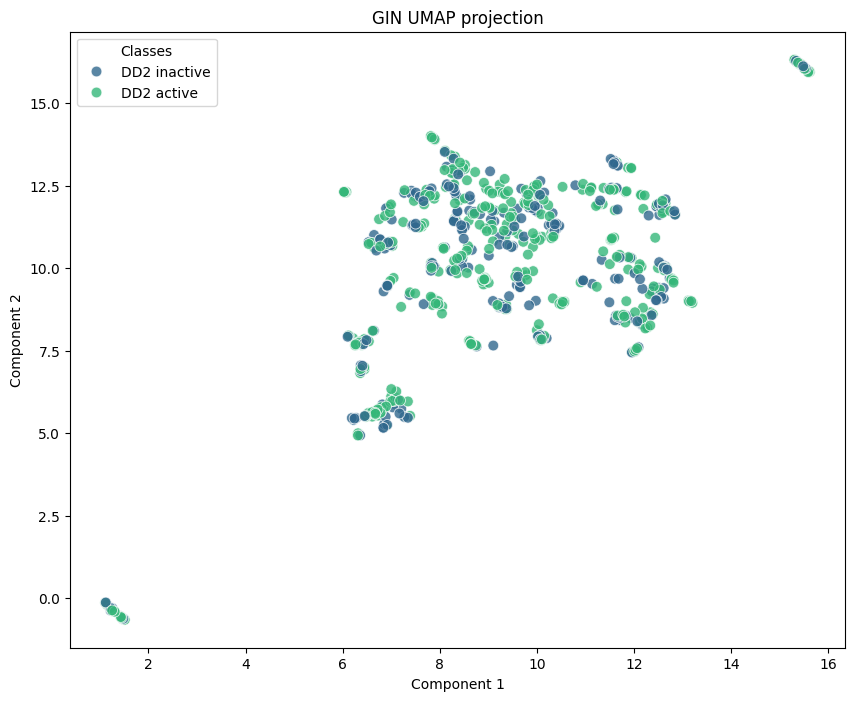

In [38]:
batch_gin_embeddings_umap = visuals.reduce_and_plot(
    data=batch_gin_embeddings.detach().to("cpu"),
    actuals=test_labels[:],
    method="umap",
    n_components=2,
    random_state=seed,
    n_neighbors=20,
    min_dist=0.1,title="GIN UMAP projection"
    
)

torch.Size([174])
DataCustomBatch(x=[21277, 73], edge_index=[2, 67835], edge_attr=[67835, 24], global_feats=[676, 85], y=[676], batch=[21277], ptr=[677])
global_feats shape torch.Size([676, 174])
global_feats torch.Size([676, 174])
batch_gat_embeddings:  torch.Size([676, 372])


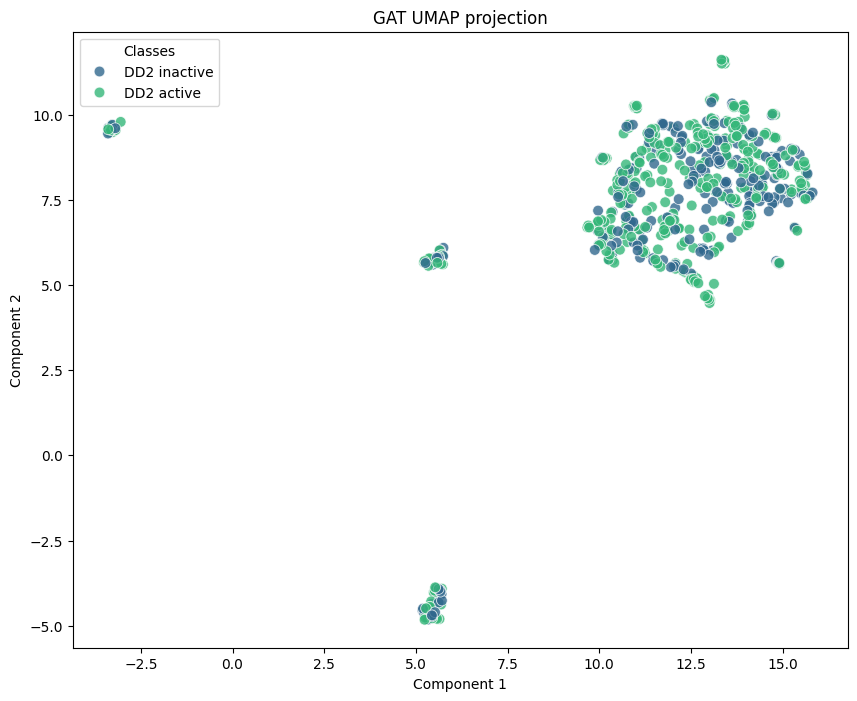

In [39]:
print(gat_graphs_from_test_mols[0].global_feats.shape)
gat_batch_from_test_mols = CustomBatch.from_data_list(gat_graphs_from_test_mols).to("cpu")
print(gin_batch_from_test_mols)
batch_gat_embeddings = gin_predictor.model.get_embedding(gat_batch_from_test_mols).detach()
print("batch_gat_embeddings: ", batch_gat_embeddings.shape)

batch_gat_embeddings_umap = visuals.reduce_and_plot(
    data=batch_gat_embeddings.detach().to("cpu"),
    actuals=test_labels[:],
    method="umap",
    n_components=2,
    random_state=seed,
    n_neighbors=20,
    min_dist=0.1,
    title="GAT UMAP projection"
)